# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from datetime import timedelta
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

from xgboost import XGBClassifier

# Main Pipeline

## Load Data

In [2]:
####################################################################
# LOAD DATA
####################################################################
raw = pd.read_csv('InterviewPdMUseCase/raw_sensor_readings.csv')
monitor = pd.read_csv('InterviewPdMUseCase/monitor_parameters.csv')
pm = pd.read_csv('InterviewPdMUseCase/pm_time.csv', parse_dates=['timestamp', 'date'])

# Dropping useless columns
raw = raw.drop(['Unnamed: 0'], axis=1)
monitor = monitor.drop(columns=['chamber', 'Unnamed: 0'], errors='ignore') # Chamber not included

In [3]:
raw.head()

,lot_id,parameter,value,recipe_id,substrate_id,step_id,sum_dtts
0,lotA0,MFC2Flow_STEP_MEAN,75.031250,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272
1,lotA0,MFC5Flow_STEP_MEAN,81.068263,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272
2,lotA0,Pressure100TorrManometer_STEP_MEAN,11.998871,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272
3,lotA0,UPC1-Flow_STEP_MEAN,693.075212,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272
4,lotA0,MFCGFlow_STEP_MEAN,74.995839,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272


In [4]:
monitor.head()

,sample_date,parameter,value,sigma,ucl,center,lcl,sigma_ucl,sigma_center,sigma_lcl
0,2022-12-27 11:21:44,RS,0.700091,0.010509,0.7185,0.702,0.6885,0.016852,0.0105,0.0051
1,2022-12-27 11:21:44,REF,102.916526,0.358519,105.4650,103.635,101.8050,0.675000,0.3000,0.0750
2,2022-12-29 13:53:22,REF,102.718235,0.350724,105.4650,103.635,101.8050,0.675000,0.3000,0.0750
3,2022-12-29 13:53:22,RS,0.699621,0.009467,0.7185,0.702,0.6885,0.016852,0.0105,0.0051
4,2022-12-30 10:48:08,RS,0.709131,0.007998,0.7185,0.702,0.6885,0.016852,0.0105,0.0051


In [5]:
pm.head()

,Unnamed: 0,date,timestamp
0,148108,2022-12-02,2022-12-02 05:45:55.875
1,182065,2023-02-05,2023-02-05 11:23:44.816
2,225487,2023-04-28,2023-04-28 03:16:33.227
3,267242,2023-07-14,2023-07-14 12:31:32.211
4,267253,2023-07-20,2023-07-20 10:33:39.914


## Filter data for BMK3 flow

In [6]:
####################################################################
# FILTER FOR BKM3 FLOW
####################################################################
print('Data Len (Original):', len(raw))
raw = raw[raw['parameter'].str.contains('STEP_MEAN')]
raw = raw[raw['step_id']==10]

print('Data Len (Filter step_id):', len(raw))
raw = raw[raw['recipe_id'].str.contains(r'RecipeC3|C0|C1|C4')]

print('Data Len (remove some recipe):', len(raw))

raw = raw.reset_index(drop=True)

Data Len (Original): 1099999
Data Len (Filter step_id): 453772
Data Len (remove some recipe): 452793


In [7]:
raw.head()

,lot_id,parameter,value,recipe_id,substrate_id,step_id,sum_dtts
0,lotA0,MFC2Flow_STEP_MEAN,75.031250,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272
1,lotA0,MFC5Flow_STEP_MEAN,81.068263,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272
2,lotA0,Pressure100TorrManometer_STEP_MEAN,11.998871,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272
3,lotA0,UPC1-Flow_STEP_MEAN,693.075212,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272
4,lotA0,MFCGFlow_STEP_MEAN,74.995839,RecipeC0,WaferB0,10,2023-01-01 01:19:32.272


## Aggregate sensor per timestamp

In [8]:
####################################################################
# AGGREGATE SENSOR FEATURES per timestamp + lot
####################################################################
feat = raw.pivot_table(
    index=['lot_id','sum_dtts'],
    columns='parameter',
    values='value',
    aggfunc=['mean']
)
feat.columns = ['_'.join(col).strip() for col in feat.columns]
feat = feat.reset_index()

columns = feat.columns
columns = [x.replace('mean_', '') for x in columns]
feat.columns = columns

In [9]:
feat.head()

,lot_id,sum_dtts,MFC2Flow_STEP_MEAN,MFC5Flow_STEP_MEAN,MFCEFlow_STEP_MEAN,MFCGFlow_STEP_MEAN,MFCJFlow_STEP_MEAN,MFCKFlow_STEP_MEAN,MFCNFlow_STEP_MEAN,MFCXFlow_STEP_MEAN,Pressure100TorrManometer_STEP_MEAN,ThrottleValveAngle_STEP_MEAN,UPC1-Flow_STEP_MEAN
0,lotA0,2023-01-01 01:19:32.272,75.031250,81.068263,81.079901,74.995839,60.050699,60.042968,134.953860,0.002235,11.998871,5.970492,693.075212
1,lotA0,2023-01-01 01:20:47.457,75.032446,81.070509,81.067650,74.998710,60.055338,60.047607,134.935338,0.000000,11.998991,5.970984,684.538296
2,lotA0,2023-01-01 01:22:03.274,75.055176,81.063698,81.067140,74.992968,60.056682,60.047607,134.953860,0.000000,11.995389,5.987705,689.890975
3,lotA0,2023-01-01 01:23:18.273,75.055175,81.074567,81.068263,75.001581,60.055338,60.047607,134.953860,0.002235,11.998511,5.972459,661.290503
4,lotA0,2023-01-01 01:24:36.298,75.029754,81.075001,81.079902,74.992968,60.056884,60.047607,134.953860,0.006823,11.997911,5.951311,674.452482


## Get labels based on RS/REF beyond control limit

In [10]:
####################################################################
# LABEL TARGET BASED ON RS/REF BEYOND CONTROL LIMIT
####################################################################
monitor['out_of_control'] = (
    ((monitor['value'] > monitor['ucl']) | (monitor['value'] < monitor['lcl'])) |
    ((monitor['sigma'] > monitor['sigma_ucl']) | (monitor['sigma'] < monitor['sigma_lcl']))
)

lab = monitor.groupby('sample_date')['out_of_control'].max().reset_index()
lab.rename(columns={'sample_date':'sum_dtts','out_of_control':'y'}, inplace=True)

print(Counter(lab['y']))

Counter({False: 265, True: 3})


In [11]:
lab

,sum_dtts,y
0,2022-12-27 11:21:44,False
1,2022-12-29 13:53:22,False
2,2022-12-30 10:48:08,False
3,2022-12-31 17:53:48,False
4,2023-01-02 19:45:56,False
...,...,...
263,2023-11-24 04:40:01,False
264,2023-11-25 06:44:36,False
265,2023-11-26 12:06:58,False
266,2023-11-27 10:57:37,False


In [12]:
lab[lab['y']==True]

,sum_dtts,y
137,2023-06-07 01:15:39,True
140,2023-06-09 19:32:38,True
156,2023-06-29 10:14:47,True


## Merge features and labels

Only assign labels with a tolerance of 6h

In [13]:
####################################################################
# MERGE FEATURES & LABELS
####################################################################
feat['sum_dtts'] = pd.to_datetime(feat['sum_dtts'])
lab['sum_dtts'] = pd.to_datetime(lab['sum_dtts'])

feat = feat.sort_values('sum_dtts')
lab = lab.sort_values('sum_dtts')

df = pd.merge_asof(feat, lab, on='sum_dtts', direction='nearest', tolerance=pd.Timedelta('6h'))
df = df.dropna(subset=['y'])

print(Counter(df['y']))

Counter({False: 11640, True: 90})


In [14]:
df.head()

,lot_id,sum_dtts,MFC2Flow_STEP_MEAN,MFC5Flow_STEP_MEAN,MFCEFlow_STEP_MEAN,MFCGFlow_STEP_MEAN,MFCJFlow_STEP_MEAN,MFCKFlow_STEP_MEAN,MFCNFlow_STEP_MEAN,MFCXFlow_STEP_MEAN,Pressure100TorrManometer_STEP_MEAN,ThrottleValveAngle_STEP_MEAN,UPC1-Flow_STEP_MEAN,y
354,lotA28,2023-01-02 15:19:16.680,75.010913,81.063848,81.075001,74.990097,60.057095,60.042863,134.953860,0.006823,11.999352,5.965574,698.852941,False
355,lotA28,2023-01-02 15:20:31.685,75.043212,81.070219,81.061524,74.990097,60.046094,60.044582,134.953860,0.002235,11.997070,5.964590,687.045341,False
356,lotA28,2023-01-02 15:21:47.682,75.053979,81.068045,81.061524,74.999041,60.055170,60.049120,134.932252,0.000000,11.999433,5.977258,683.044825,False
357,lotA28,2023-01-02 15:23:02.679,75.043213,81.068263,81.061524,74.998710,60.050699,60.046061,134.975465,0.000000,12.000312,5.972459,660.036981,False
358,lotA28,2023-01-02 15:24:20.685,75.007324,81.070509,81.061524,75.001581,60.056884,60.039875,134.953860,0.004549,12.000672,5.921803,660.418802,False


## Get time since last PM features

In [15]:
####################################################################
# TIME-SINCE-LAST-PM FEATURE
####################################################################
pm = pm.sort_values('timestamp')

df['sum_dtts'] = pd.to_datetime(df['sum_dtts'])
df = df.sort_values('sum_dtts')
df['last_pm'] = df['sum_dtts'].apply(lambda t: pm[pm['timestamp']<=t]['timestamp'].max())
df['days_since_pm'] = (df['sum_dtts'] - df['last_pm']).dt.days.fillna(999)
df = df.reset_index(drop=True)

print(Counter(df['y']))

Counter({False: 11640, True: 90})


In [16]:
df.head()

,lot_id,sum_dtts,MFC2Flow_STEP_MEAN,MFC5Flow_STEP_MEAN,MFCEFlow_STEP_MEAN,MFCGFlow_STEP_MEAN,MFCJFlow_STEP_MEAN,MFCKFlow_STEP_MEAN,MFCNFlow_STEP_MEAN,MFCXFlow_STEP_MEAN,Pressure100TorrManometer_STEP_MEAN,ThrottleValveAngle_STEP_MEAN,UPC1-Flow_STEP_MEAN,y,last_pm,days_since_pm
0,lotA28,2023-01-02 15:19:16.680,75.010913,81.063848,81.075001,74.990097,60.057095,60.042863,134.953860,0.006823,11.999352,5.965574,698.852941,False,2022-12-02 05:45:55.875,31
1,lotA28,2023-01-02 15:20:31.685,75.043212,81.070219,81.061524,74.990097,60.046094,60.044582,134.953860,0.002235,11.997070,5.964590,687.045341,False,2022-12-02 05:45:55.875,31
2,lotA28,2023-01-02 15:21:47.682,75.053979,81.068045,81.061524,74.999041,60.055170,60.049120,134.932252,0.000000,11.999433,5.977258,683.044825,False,2022-12-02 05:45:55.875,31
3,lotA28,2023-01-02 15:23:02.679,75.043213,81.068263,81.061524,74.998710,60.050699,60.046061,134.975465,0.000000,12.000312,5.972459,660.036981,False,2022-12-02 05:45:55.875,31
4,lotA28,2023-01-02 15:24:20.685,75.007324,81.070509,81.061524,75.001581,60.056884,60.039875,134.953860,0.004549,12.000672,5.921803,660.418802,False,2022-12-02 05:45:55.875,31


## Split data

Split data via split from last seen anomaly

In [17]:
####################################################################
# SPLIT DATA
####################################################################
X = df.drop(columns=['lot_id','sum_dtts','last_pm','y'])
y = df['y'].astype(int)

# Calculate the split index by finding the last anomaly
anomalies = df[df['y'] == True]
latest_anomaly_index = anomalies.index[-5]

# Split just after that
split_index = latest_anomaly_index

# Split the data chronologically
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separate features and target
X_train = train_df.drop(columns=['lot_id', 'sum_dtts', 'last_pm', 'y'])
y_train = train_df['y'].astype(int)

X_test = test_df.drop(columns=['lot_id', 'sum_dtts', 'last_pm', 'y'])
y_test = test_df['y'].astype(int)

print('Train Counter:', Counter(y_train))
print('Test Counter :', Counter(y_test))

Train Counter: Counter({0: 6401, 1: 85})
Test Counter : Counter({0: 5239, 1: 5})


## Preprocess data

In [18]:
####################################################################
# PREPROCESS FEATURES
####################################################################
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model selection

Use gridsearch to find best parameters

In [19]:
####################################################################
# MODEL SELECTION (XGBoost classifier)
####################################################################
# Rescaling factor
neg = sum(y_train == 0)
pos = sum(y_train == 1)
scale = neg / pos * 0.5
print('Scale:', scale)

xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42,
    scale_pos_weight=scale
    )

params = {
    'n_estimators': [50, 100], 
    'max_depth':[3, 5, 7], 
    'learning_rate':[0.01, 0.1]
    }

clf = GridSearchCV(
    xgb, 
    params, 
    cv=3, 
    scoring='f1', 
    n_jobs=-1
    )

clf.fit(X_train, y_train)

print("Best Params:", clf.best_params_)

Scale: 37.65294117647059
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


## Evaluation

ROC-AUC and BAC

In [20]:
####################################################################
# EVALUATION
####################################################################
pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)[:,1]

roc = roc_auc_score(y_test, probs)
bal_acc = balanced_accuracy_score(y_test, pred)

print("Classification Report:\n", classification_report(y_test, pred))
print("ROC-AUC:", round(roc, 3))
print("BAC:", round(bal_acc, 3))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      5239
           1       0.02      1.00      0.03         5

    accuracy                           0.94      5244
   macro avg       0.51      0.97      0.50      5244
weighted avg       1.00      0.94      0.97      5244

ROC-AUC: 0.986
BAC: 0.971


Confusion matrix:
 [[4936  303]
 [   0    5]]


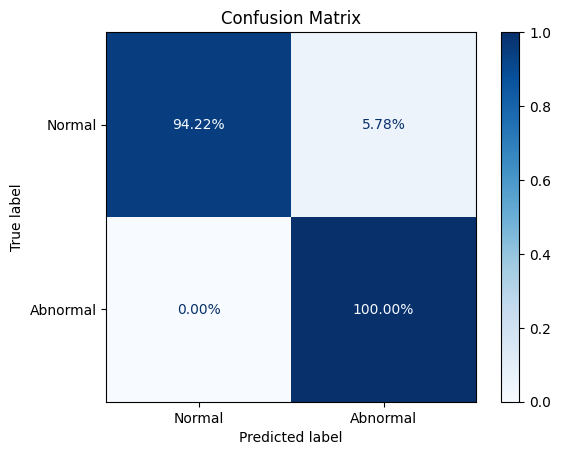

In [21]:
cm = confusion_matrix(y_test, pred)
print("Confusion matrix:\n", cm)

# Normalize by true labels (rows)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Normal', 'Abnormal'])
disp.plot(cmap=plt.cm.Blues, values_format='.2%')
plt.title("Confusion Matrix")
plt.show()

## Get features importance

It appears the most important features are:
- UPC1-Flow_STEP
- days_since_pm
- MFCGFlow_STEP

This shows that having regular maintenance is important for predictive maintenance

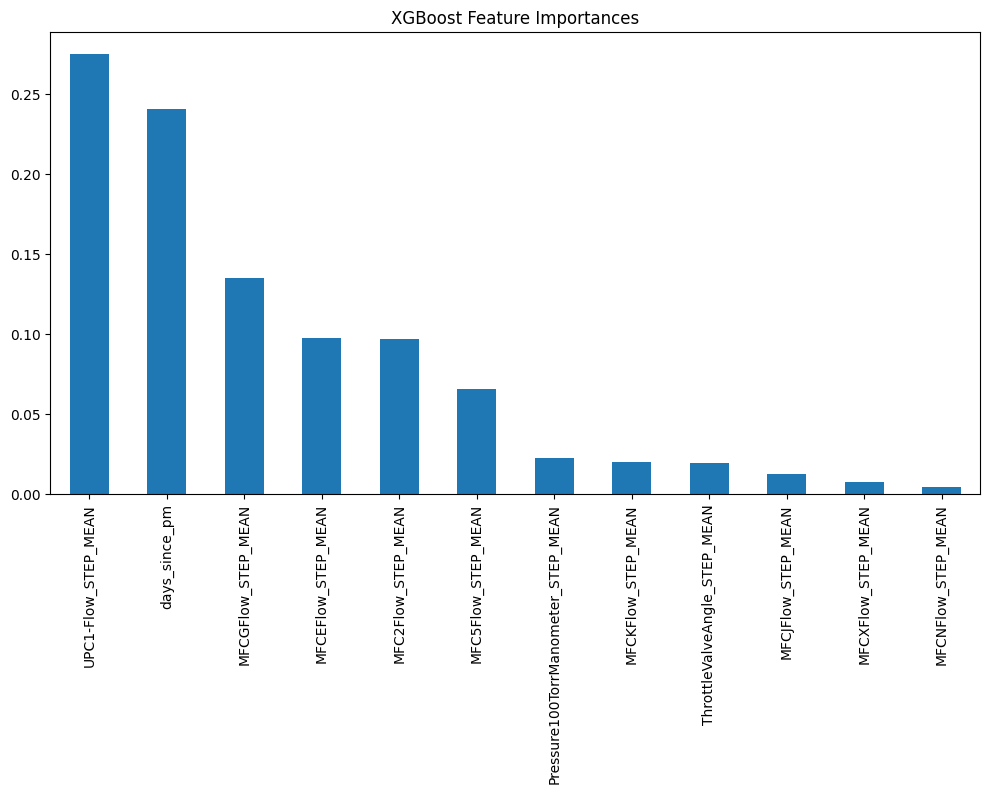

In [22]:
####################################################################
# FEATURE IMPORTANCE
####################################################################
importances = clf.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(12, 6))
plt.title("XGBoost Feature Importances")
plt.show()

In [23]:
feat_imp

UPC1-Flow_STEP_MEAN                   0.275105
days_since_pm                         0.241137
MFCGFlow_STEP_MEAN                    0.135096
MFCEFlow_STEP_MEAN                    0.097710
MFC2Flow_STEP_MEAN                    0.096858
MFC5Flow_STEP_MEAN                    0.065931
Pressure100TorrManometer_STEP_MEAN    0.022596
MFCKFlow_STEP_MEAN                    0.020351
ThrottleValveAngle_STEP_MEAN          0.019816
MFCJFlow_STEP_MEAN                    0.012796
MFCXFlow_STEP_MEAN                    0.007780
MFCNFlow_STEP_MEAN                    0.004825
dtype: float32